In [42]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import random
import statsmodels.api as sm
from IPython.display import display, HTML

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import MinMaxScaler


from core.operation import *
from class_model.model_prep import ModelPrep 

import warnings

warnings.filterwarnings('ignore')

In [43]:
# Params
live = True
stock = read_stock(get_large(live) / 'permno_live.csv')
start = '2005-01-01'
window = 168
threshold = 8_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
past_date = '2023-11-09'
current_date = '2023-11-10'
format_end = date.today().strftime('%Y%m%d')
trial = f'mrev_{format_end}'
dir_path = Path(get_strat_mrev_etf() / 'report')
sbo = 0.85
sso = 0.85
sbc = 0.25
ssc = 0.25
etf_list = ['QQQ', 'XLE', 'XLV', 'VNQ', 'XLB', 'XLF', 'XLY', 'XLI', 'XLU', 'XLP']
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

In [3]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

# Past

In [4]:
# Find correlation between returns
def corr(df):
    # Unstack the DataFrame to get ticker returns in separate columns
    unstacked_df = df.unstack(level='ticker')
    returns_df = unstacked_df['RET_01']

    # Calculate the correlation matrix
    correlation_matrix = returns_df.corr()

    # Print pairwise correlations
    tickers = correlation_matrix.columns
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            print(f"Correlation between {tickers[i]} and {tickers[j]}: {correlation_matrix.iloc[i, j]:.4f}")

In [5]:
# Read in ETF data from FMP
T = [1]
sector_ret_past = get_data_fmp(ticker_list=etf_list, start=start, current_date=past_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})
sector_ret_past = sector_ret_past.loc[~sector_ret_past.index.duplicated(keep='first')]
# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
corr(sector_ret_past)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/ticker]

Correlation between XLB and XLE: 0.7573
Correlation between XLB and XLF: 0.7366
Correlation between XLB and XLI: 0.8667
Correlation between XLB and XLK: 0.7497
Correlation between XLB and XLP: 0.6516
Correlation between XLB and XLU: 0.5797
Correlation between XLB and XLV: 0.6891
Correlation between XLB and XLY: 0.7617
Correlation between XLE and XLF: 0.6305
Correlation between XLE and XLI: 0.7184
Correlation between XLE and XLK: 0.5898
Correlation between XLE and XLP: 0.5109
Correlation between XLE and XLU: 0.5208
Correlation between XLE and XLV: 0.5494
Correlation between XLE and XLY: 0.5887
Correlation between XLF and XLI: 0.8062
Correlation between XLF and XLK: 0.7031
Correlation between XLF and XLP: 0.6295
Correlation between XLF and XLU: 0.5162
Correlation between XLF and XLV: 0.6422
Correlation between XLF and XLY: 0.7679
Correlation between XLI and XLK: 0.7957
Correlation between XLI and XLP: 0.7182
Correlation between XLI and XLU: 0.6043
Correlation between XLI and XLV: 0.7417


In [47]:
asdf = permno_random.copy()

In [206]:
tic = pd.read_parquet(get_parquet(live) / 'data_ticker.parquet.brotli')

In [226]:
get_stock_data(tic, asdf).ticker.unique()

array(['TROW', 'AVAN', 'CLDX', 'XOMA', 'ED', 'LH', 'IBM', 'SLB', 'VMC',
       'AA', 'SPEX', 'AIKI', 'DOMH', 'CAT', 'CL', 'LMT', 'NEM', 'PPG',
       'MMM', 'CINF', 'TXT', 'FPL', 'NEE', 'ARNC', 'HWM', 'OKE', 'BAX',
       'PNW', 'APD', 'BP', 'OXY', 'RF', 'SHW', 'CMI', 'VFC', 'LRCX',
       'TGT', 'RHI', 'MU', 'WMT', 'ITW', 'BLL', 'BALL', 'NABI', 'BOTA',
       'AVIR', 'VXRT', 'BAC', 'SNA', 'PNC', 'CTL', 'LUMN', 'ADI', 'LOW',
       'AOC', 'AON', 'KEY', 'USB', 'HDI', 'HOG', 'C', 'ABX', 'GOLD',
       'STT', 'PXD', 'SYMC', 'NLOK', 'GEN', 'EOG', 'POT', 'NTR', 'CSCO',
       'HOLX', 'TRMB', 'TM', 'NTN', 'BTX', 'ERNA', 'KIM', 'SNPS', 'ORLY',
       'AZN', 'IT', 'INCY', 'EMN', 'BVF', 'VRX', 'BHC', 'SIRI', 'O',
       'ASML', 'DLTR', 'EL', 'CHKP', 'NOI', 'NOV', 'ROK', 'RYAAY', 'AME',
       'TSM', 'MFA', 'NVDA', 'FFIV', 'AKAM', 'UPS', 'CLN', 'CLSN', 'IMNN',
       'NVS', 'BG', 'DB', 'SNY', 'CMCSA', 'WYNN', 'NRP', 'NRG', 'LVS',
       'SLW', 'WPM', 'EXPE', 'LBTYK', 'ICE'], dtype=object)

In [229]:
past_data = set_length(past_data, 18) # 575 tickers
permno_list = past_data.index.get_level_values('permno').unique()
permno_random = random.sample(list(permno_list), 100) # Randomly Sample 100 Tickers
past_data = get_stocks_data(past_data, asdf)

In [230]:
# Export permnos
unique_permnos = past_data.index.get_level_values('permno').unique().tolist()
permno_df = pd.DataFrame(unique_permnos, columns=['permno'])
permno_df.to_csv(get_large(live) / 'permno_mrev_etf.csv', index=False, header=False)

In [6]:
stock = read_stock(get_large(live) / 'permno_mrev_etf.csv')

In [194]:
ticker = ['TM', 'NABI', 'BOTA', 'AVIR', 'VXRT', 'MFA', 'IT', 'LMT', 'CLN',
       'CLSN', 'IMNN', 'AKAM', 'BAX', 'XOMA', 'FFIV', 'EMN', 'PKI', 'KIM',
       'EXPE', 'SPEX', 'AIKI', 'DOMH', 'CINF', 'MMP', 'NRG', 'TRMB',
       'SHW', 'CMCSA', 'ABX', 'GOLD', 'ICE', 'SLW', 'WPM', 'LBTYK',
       'LRCX', 'APD', 'TGT', 'LH', 'FPL', 'NEE', 'EOG', 'MMM', 'DB',
       'IBM', 'RYAAY', 'AVAN', 'CLDX', 'HDI', 'HOG', 'ED', 'BVF', 'VRX',
       'BHC', 'PNC', 'BLL', 'BALL', 'AA', 'ARNC', 'HWM', 'STT', 'VMC',
       'NEM', 'CL', 'CHKP', 'CTL', 'LUMN', 'AME', 'ORLY', 'USB', 'LVS',
       'O', 'CAT', 'SLB', 'WYNN', 'PNW', 'SIRI', 'SNA', 'TSM', 'WMT',
       'VFC', 'HOLX', 'KEY', 'TXT', 'DLTR', 'NVS', 'AZN', 'RHI', 'SNY',
       'NTN', 'BTX', 'ERNA', 'TROW', 'SNPS', 'NOI', 'NOV', 'CSCO', 'BG',
       'NRP', 'BP', 'ITW', 'OKE', 'MU', 'POT', 'NTR', 'C', 'ROK', 'OXY',
       'CMI', 'NVDA', 'LOW', 'UPS', 'AOC', 'AON', 'INCY', 'PXD', 'ADI',
       'ASML', 'EL', 'BAC', 'PPG', 'MJES', 'COOL', 'PTE', 'RF', 'SYMC',
       'NLOK', 'GEN']

In [402]:
stock = read_stock(get_large(live) / 'permno_mrev_mkt.csv')

In [7]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

In [8]:
past_data = set_length(past_data, 15) # 575 tickers
permno_list = past_data.index.get_level_values('permno').unique()
permno_random = random.sample(list(permno_list), 100) # Randomly Sample 100 Tickers
past_data = get_stocks_data(past_data, stock)

In [9]:
# Execute Rolling LR
beta_data_past = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')

In [10]:
# Retrieve Needed Data
beta_data_past = beta_data_past[beta_data_past.columns[1:14]]
beta_data_past = beta_data_past.fillna(0)

In [11]:
# Calculate rolling mean and standard deviation
rolling_mean = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
beta_data_past['s_score'] = (beta_data_past[f'epsil_sector_01_{window:02}'] - rolling_mean) / rolling_std

In [12]:
# # Export data
# beta_data_past.to_parquet(get_strategy_mrev_etf_data() / 'data_beta_etf.parquet.brotli', compression='brotli')

In [13]:
# Convert ETF Dataframe to multi-index
stock = read_stock(get_large(live) / 'permno_live.csv')
sector_multi_past = create_multi_index(sector_ret_past, stock)
# Merge the necessary columns together into one dataframe
combined_past = beta_data_past.merge(sector_multi_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(past_data[['RET_01']], left_index=True, right_index=True, how='left')
combined_past = combined_past.fillna(0)

In [14]:
# Retrieve the needed columns
ret_columns = [col for col in combined_past.columns if "RET_01" in col]
combined_past = combined_past[['s_score'] + ret_columns]

In [44]:
def create_signal_past(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo) & (group['market_cap'] > threshold)
        open_short_condition = (group['s_score'] > sso) & (group['market_cap'] > threshold)
        close_long_condition = group['s_score'] > -ssc
        close_short_condition = group['s_score'] < sbc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                elif positions[i-1] == 'short' and close_short_condition.iloc[i]:
                    signals[i] = 'close short'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True
                elif open_short_condition.iloc[i]:
                    positions[i] = 'short'
                    signals[i] = 'sell to open'
                    position_open = True
                    current_position = 'short'

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [45]:
# Create signals
copy = combined_past.copy(deep=True)
misc = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_past = create_signal_past(copy, sbo, sso, sbc, ssc, threshold)

In [46]:
def calc_total_ret(df, etf_returns):
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()
    
    # Combine and normalize weights
    print("Normalize weights...")
    df['stock_weight'] = np.where(mask_long, 1, np.where(mask_short, -1, 0))
    
    # Normalize net hedge betas and stock weights combined
    df['abs_stock_weight'] = df['stock_weight'].abs()
    combined_weights = df.groupby('date')['abs_stock_weight'].sum() + net_hedge_betas.abs().sum(axis=1)
    df['normalized_weight'] = df['stock_weight'].div(combined_weights, axis=0)
    normalized_net_hedge_betas = net_hedge_betas.div(combined_weights, axis=0)
    
    # Get net hedge return
    print("Get net hedge returns...")
    net_hedge_returns = pd.DataFrame(index=normalized_net_hedge_betas.index)
    for beta in beta_columns:
        etf_return_column = beta.split('_sector_')[0]
        if etf_return_column in etf_returns.columns:
            net_hedge_returns[beta] = normalized_net_hedge_betas[beta] * etf_returns[etf_return_column]
    
    # Get total hedge return
    print("Get total hedge return...")
    net_hedge_return_total = net_hedge_returns.sum(axis=1)
    
    print("Get daily returns...")
    daily_returns = (df['RET_01'] * df['normalized_weight']).groupby('date').sum()
    
    print("Get total returns...")
    total_returns = daily_returns + net_hedge_return_total
    
    return total_returns, daily_returns, net_hedge_return_total, normalized_net_hedge_betas, df[['normalized_weight']]

In [47]:
result_past_copy = result_past.copy(deep=True)

In [48]:
result_past_copy['RET_01'] = result_past_copy.groupby('permno')['RET_01'].shift(-1)

In [49]:
# Calculate strategy's return
ewp_ret, daily_ret, hedge_ret, beta_weight, stock_weight = calc_total_ret(result_past_copy, sector_ret_past.shift(-1))

Get hedge weights...
Get net hedge betas...
Normalize weights...
Get net hedge returns...
Get total hedge return...
Get daily returns...
Get total returns...


In [50]:
x = stock_weight.loc[stock_weight.index.get_level_values('date') == '2023-11-09']
x = x.loc[x.normalized_weight != 0]
print("Number of unique permnos: ", len(x.index.get_level_values('permno').unique()))

Number of unique permnos:  26


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-08-31   2005-08-31
End Period                 2023-11-09   2023-11-09
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          258.4%       717.86%
CAGR﹪                     4.96%        8.3%

Sharpe                     0.46         2.24
Prob. Sharpe Ratio         97.37%       100.0%
Smart Sharpe               0.45         2.21
Sortino                    0.64         3.93
Smart Sortino              0.63         3.87
Sortino/√2                 0.45         2.78
Smart Sortino/√2           0.44         2.74
Omega                      1.56         1.56

Max Drawdown               -56.47%      -4.65%
Longest DD Days            1982         318
Volatility (ann.)          19.66%       5.22%
R^2                        0.0          0.0
Information Ratio          0.01         0.01
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-04-15,2021-10-22,2022-01-05,266,-4.645854,-4.482409
2,2019-12-10,2020-03-23,2020-03-25,107,-4.093493,-3.298403
3,2009-02-24,2009-03-17,2009-03-26,31,-3.974419,-3.788574
4,2010-12-31,2011-06-06,2011-08-01,214,-3.936271,-3.692617
5,2009-08-20,2009-09-14,2009-09-24,36,-3.319587,-3.232168


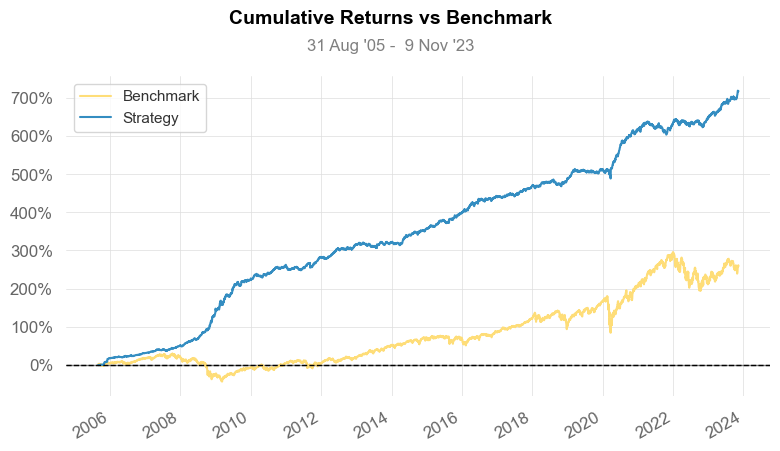

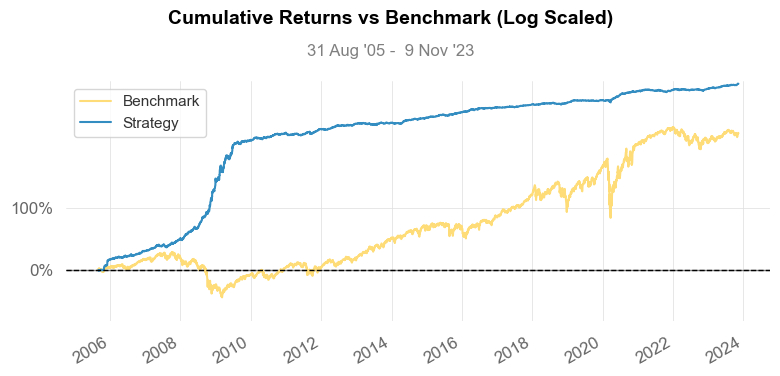

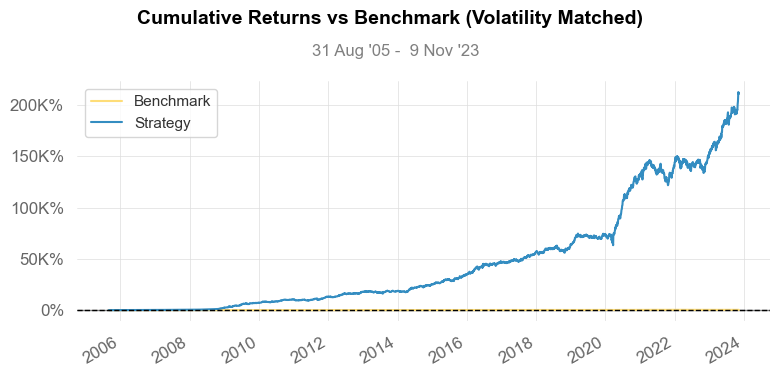

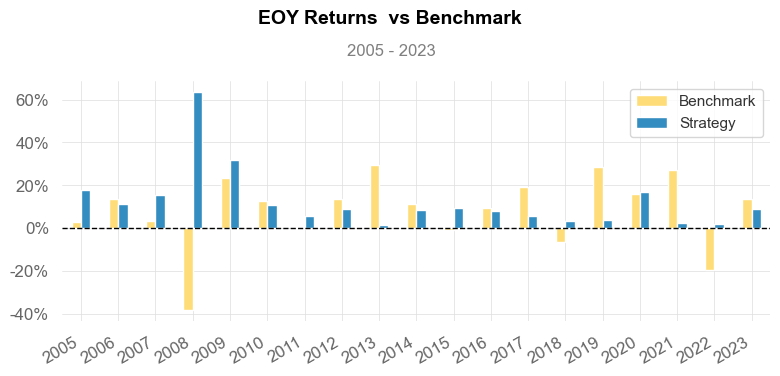

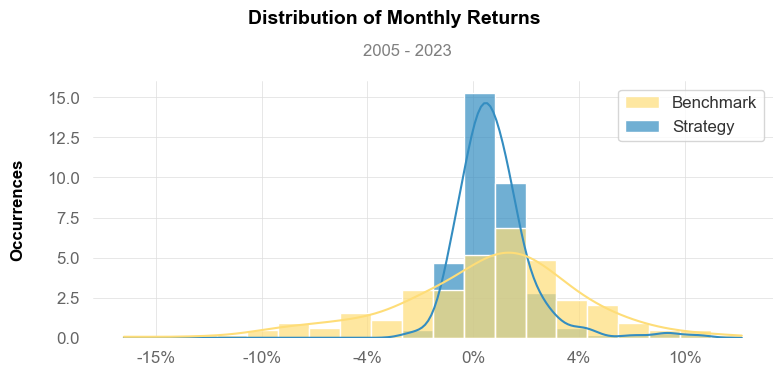

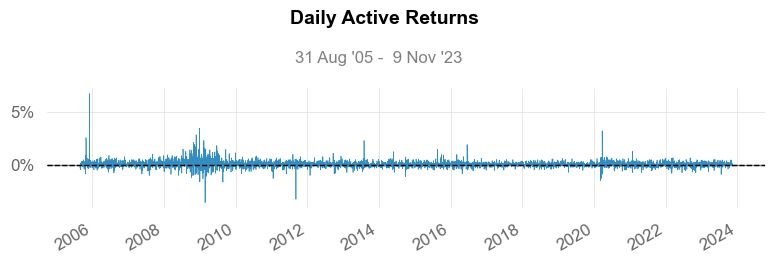

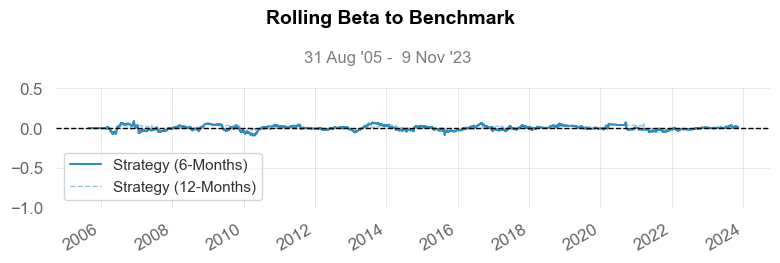

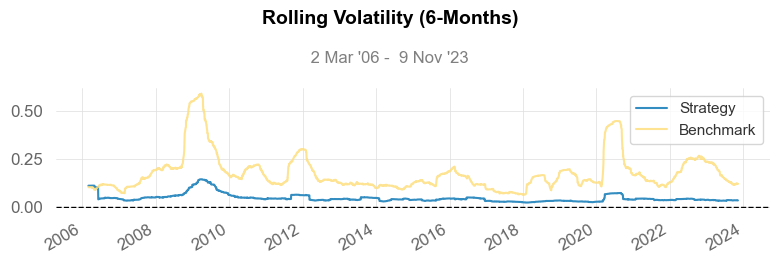

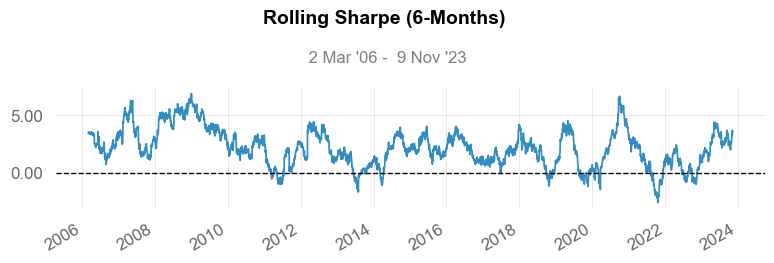

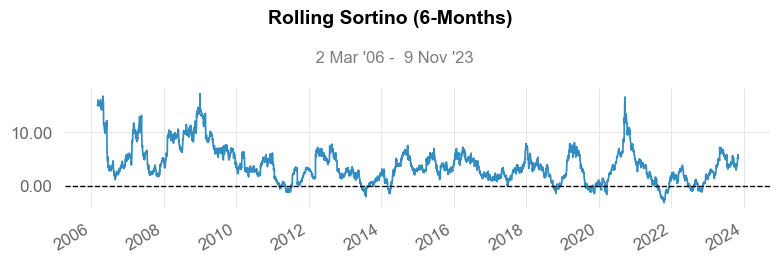

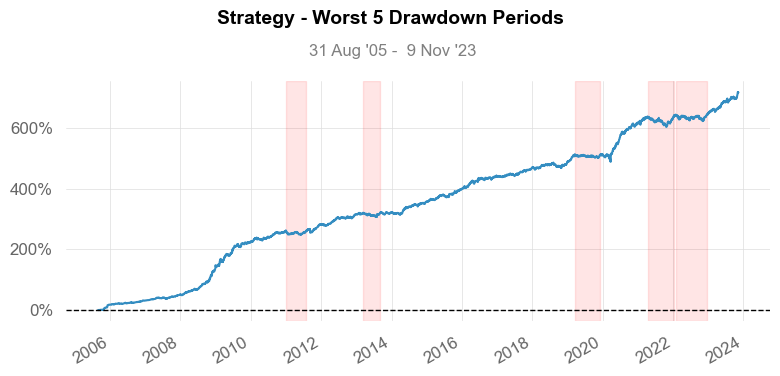

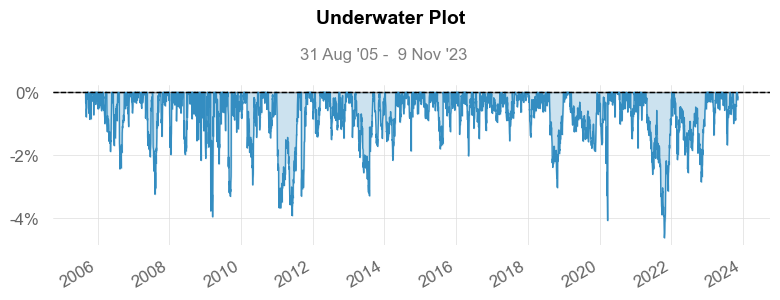

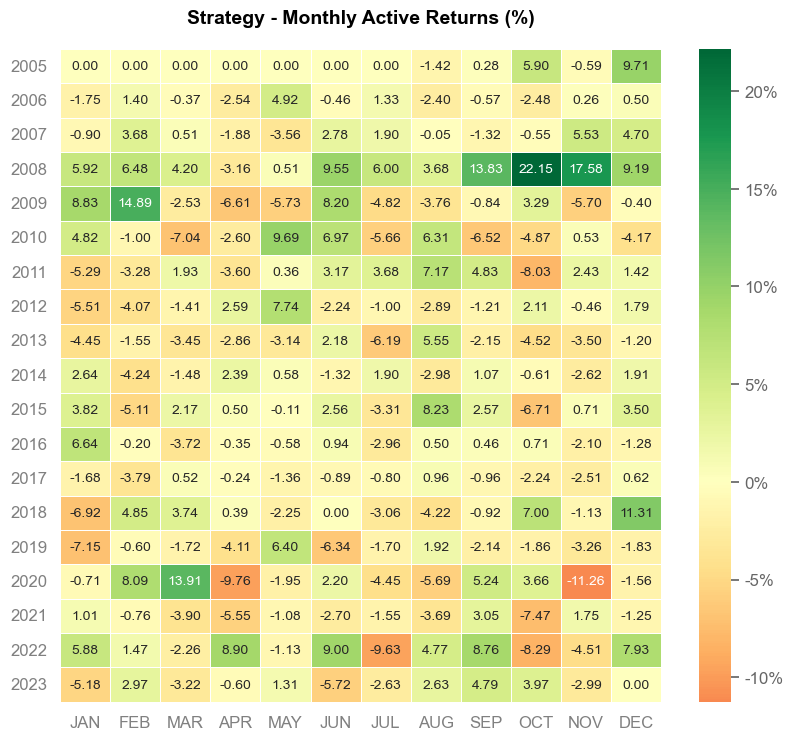

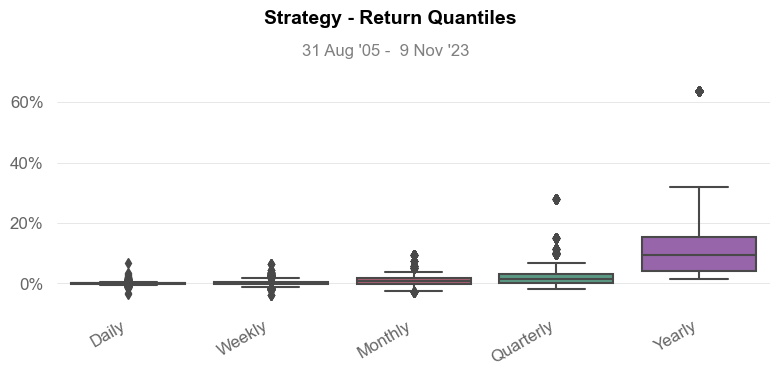

In [51]:
# Plot Results
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.full(ewp_ret, spy)